## Imports

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


## Import utility functions

In [2]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 42

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## 1. ETL (Extract, Transform, Load)

In [5]:
df = pd.read_csv('datasets/all_users_removed_noise.csv')
df

,MeterID,DATE-Time,KWH,user
0,6200093839,2021-01-01 00:00:00,0.602,0
1,6200093839,2021-01-01 00:15:00,0.589,0
2,6200093839,2021-01-01 00:30:00,0.410,0
3,6200093839,2021-01-01 00:45:00,0.495,0
4,6200093839,2021-01-01 01:00:00,0.450,0
...,...,...,...,...
36923498,6200051044,2021-07-31 22:45:00,0.473,2000
36923499,6200051044,2021-07-31 23:00:00,0.461,2000
36923500,6200051044,2021-07-31 23:15:00,0.445,2000
36923501,6200051044,2021-07-31 23:30:00,0.460,2000


## 2. EDA (Exploratory Data Analysis)

In [14]:
# Updated
def clean_data(df, user_id):
    # Select the data for the specified user
    user_data = df[df['user']==int(user_id)]

    # Drop not useful columns
    user_data['DATE-Time'] = pd.to_datetime(user_data['DATE-Time'], infer_datetime_format=True)
    user_data.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_data = user_data.set_index('DATE-Time').resample("15T").mean()
    
    # Convert the index to a DatetimeIndex object
    user_data.index = pd.to_datetime(user_data.index)

    # Count the number of zero values in each day
    zero_counts = user_data.groupby(user_data.index.floor('D'))['KWH'].apply(lambda x: (x == 0).sum())

    # Get the dates where the number of zero values is less than or equal to 48
    valid_dates = zero_counts[zero_counts <= 48].index

    # Drop the dates where the number of zero values is greater than 48
    user_data = user_data[user_data.index.floor('D').isin(valid_dates)]

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_data.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_data_clean = user_data[~user_data.index.to_series().dt.date.isin(missing_dates)]
    
    if user_data_clean.empty:
        return None

    return user_data_clean

In [7]:
import random
random.seed(RANDOM_SEED)
# Get the list of unique user IDs in the DataFrame
unique_users = df['user'].unique().tolist()

def clean_multiple_users(df, num_users):

    # Randomly select `num_users` from the list of unique user IDs
    selected_users = random.sample(unique_users, num_users)

    # Call the clean_data() function for each selected user ID and concatenate the results
    all_users_clean = pd.concat([clean_data(df, user_id) for user_id in selected_users], axis=0)

    return all_users_clean, selected_users

In [15]:
all_users_clean, selected_users = clean_multiple_users(df, 100)
print("List of Seleted Users: ", selected_users)
all_users_clean

List of Seleted Users:  [1436, 254, 55, 1656, 616, 550, 503, 318, 1645, 235, 1517, 1654, 1988, 1227, 203, 1326, 949, 71, 66, 216, 492, 524, 1139, 1355, 59, 1260, 443, 1599, 1462, 1569, 944, 496, 1010, 1323, 623, 1807, 1939, 14, 1694, 1799, 359, 1562, 950, 763, 351, 483, 1704, 755, 214, 853, 223, 807, 1893, 773, 1359, 593, 1802, 95, 1629, 1036, 1206, 286, 850, 183, 1241, 656, 1851, 1412, 1390, 1972, 1922, 813, 1297, 427, 1575, 162, 100, 1486, 514, 1725, 648, 185, 1909, 1933, 231, 1022, 1427, 1863, 821, 366, 833, 798, 471, 1504, 598, 1570, 1531, 1459, 166, 1370]


,KWH
DATE-Time,
2021-01-01 00:00:00,0.232
2021-01-01 00:15:00,0.238
2021-01-01 00:30:00,0.211
2021-01-01 00:45:00,0.251
2021-01-01 01:00:00,0.192
...,...
2021-07-31 22:45:00,0.057
2021-07-31 23:00:00,0.059
2021-07-31 23:15:00,0.047


In [16]:
user = clean_data(df, 1436)
user

,KWH
DATE-Time,
2021-01-01 00:00:00,0.232
2021-01-01 00:15:00,0.238
2021-01-01 00:30:00,0.211
2021-01-01 00:45:00,0.251
2021-01-01 01:00:00,0.192
...,...
2021-07-31 22:45:00,0.065
2021-07-31 23:00:00,0.066
2021-07-31 23:15:00,0.092


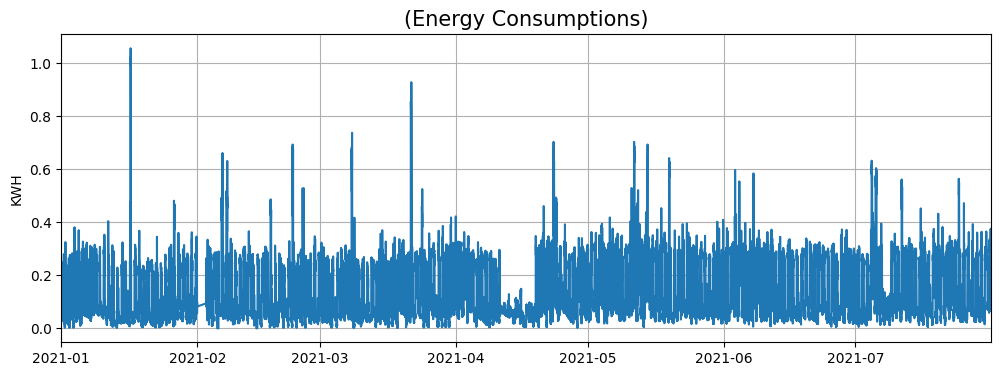

In [17]:
plt.figure(figsize=(12,4))
plt.title('(Energy Consumptions)', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(user['KWH'])
plt.show()

## 3. Prepare the data

In [18]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    windowed_data = np.reshape(data, (num_windows, window_size))
    
    return windowed_data

# Example usage
window_size = 96
data = all_users_clean.to_numpy()
windowed_data = create_windowed_dataset(data, window_size)
print(f" Window shape : {windowed_data.shape}")
print(f" Type of Window : {type(windowed_data)}")

 Window shape : (18813, 96)
 Type of Window : <class 'numpy.ndarray'>


The shape of the dataset (for selected `User_1`) is `(329, 96)` which means: 
* we have `329` samples `(i.e., 329 non-overlapping windows)`,
* each window has `96` time steps `(i.e., 96 data points)`,
* and `1` feature `(i.e., KWH)`.

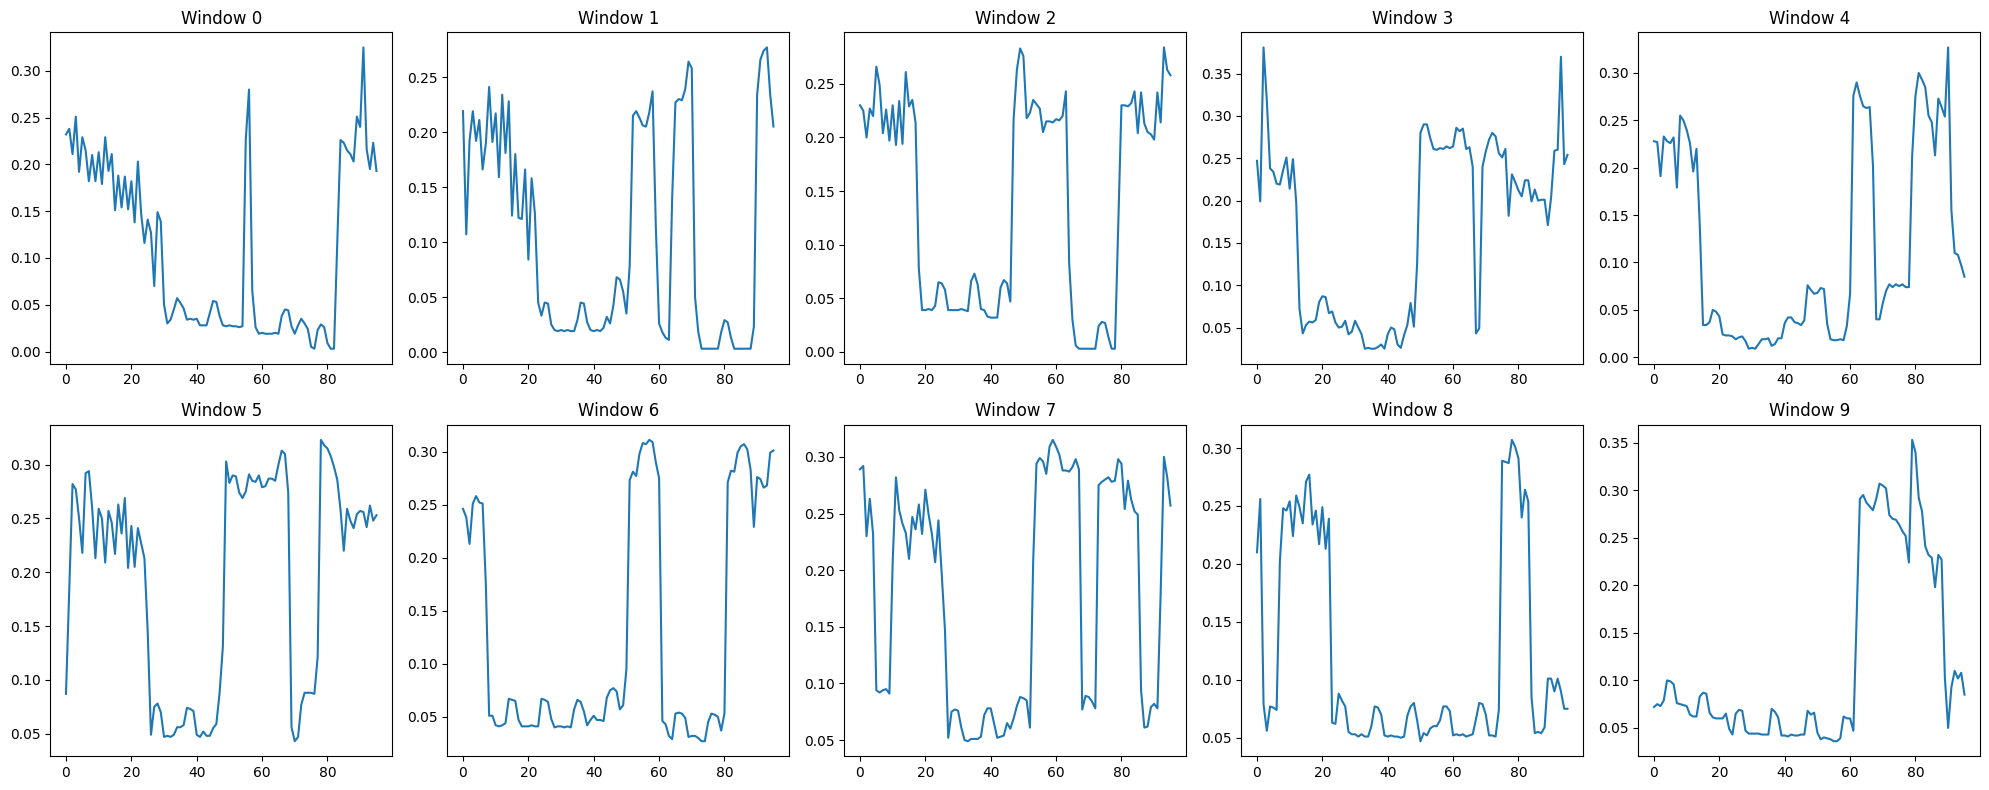

In [19]:
# Plot the first 10 windows
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.plot(windowed_data[i])
    ax.set_title(f"Window {i}")
plt.tight_layout()
plt.show()

### Divide the data into train, validation, and test sets

`train_data_tensor[:-1]` and `train_data_tensor[1:]` are indexing operations on the `train_data_tensor` PyTorch tensor.

`train_data_tensor[:-1]` means all elements of `train_data_tensor` except for the last one. 
* This is because in the context of the autoencoder model, we will be predicting the next time step based on the current time step, so the last element of train_data_tensor cannot be used as a predictor.

`train_data_tensor[1:]` means all elements of `train_data_tensor` except for the first one. 
* This is because in the context of the autoencoder model, we will be training the model to predict the next time step given the current time step, so the first element of train_data_tensor cannot be used as a prediction target.

In summary, `train_dataset` contains tuples of `input` and `target` data, where the input data is `train_data_tensor[:-1]` and the target data is `train_data_tensor[1:]`.

We'll split the examples into train, validation and test sets:

In [21]:
# Divide the data into training, validation, and test sets 
train_data, val_data = train_test_split(windowed_data, test_size=0.10, shuffle=True, random_state=RANDOM_SEED)
val_data, test_data = train_test_split(val_data, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(16931, 96)
(941, 96)
(941, 96)


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [22]:
def create_dataset(df):
    sequences = df.astype(np.float32).tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (96x1 in our case).

Let's create some datasets:

In [23]:
train_dataset, seq_len, n_features = create_dataset(train_data)
val_dataset, _, _ = create_dataset(val_data)
test_normal_dataset, _, _ = create_dataset(test_data)

### 4. Define the model

This model takes in a tensor of shape `(batch_size, sequence_length, num_features)` as input and outputs a tensor of the same shape. 

We use `Conv1d` layers for the encoder and `ConvTranspose1d` layers for the decoder.

Note that the number of input channels for the first Conv1d layer is 1, because we are using a univariate time series as input. 

If you had a multivariate time series, you would set the number of input channels to the number of features in your data.

You can adjust the number of channels and the kernel sizes of the convolutional layers to increase or decrease the complexity of the model.

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

We'll use the LSTM Autoencoder from this GitHub repo with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the Encoder:

In [24]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        # print(f"ENCODER============")
        x = x.reshape((1, self.seq_len, self.n_features))
        # print(f"x reshape: {x.shape}")

        x, (_, _) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        x, (hidden_n, _) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.reshape((self.n_features, self.embedding_dim)).shape}")

        return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

In [25]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.linear = nn.Linear(64, 128)

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # print(f"DECODER============")
        x = x.repeat(self.seq_len, self.n_features)
        # print(f"x repeat : {x.shape}")
        
        x = x.reshape((self.n_features, self.seq_len, 64))
        # print(f"x reshape : {x.shape}")
        
        x = self.linear(x)
        # print(f"x linear reshape : {x.shape}")

        x, (hidden_n, cell_n) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        # print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x, (hidden_n, cell_n) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.shape}")
        
        x = x.reshape((self.seq_len, self.hidden_dim))
        # print(f"x reshape : {x.shape}")

        return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [26]:
class VAE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(VAE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        
        self.z_mean = torch.nn.Linear(128, 64).to(device)
        self.z_log_var = torch.nn.Linear(128, 64).to(device)
        
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        # print(f"xshape: {x.shape}")
        
        mean, std = self.z_mean(x), self.z_log_var(x)
        # print(f"{mean=}")
        # print(f"{std=}")
        
        encoded = self.reparameterize(mean, std)
        # print(encoded.shape)
        
        x = self.decoder(encoded)
        # print(x.shape)

        return x, encoded, mean, std

The input shape for `Conv1d` should be `(batch_size, num_features, sequence_length)`. 

In our case, the batch size is determined by the batch_size argument in the `DataLoader`, the number of features is `1`, and the sequence length is the window size which is `96`. 

So, the shape of each input should be `(batch_size, 1, 96)`.

---

If we use `Conv2d` instead of `Conv1d`, the input shape should be `(batch_size, 1, window_size, 1)` instead of `(batch_size, window_size, 1)`.

This is because `Conv2d` expects a 4D tensor where the second dimension represents the number of channels. 

In our case, we only have one channel, so we set this dimension to `1`. The fourth dimension is set to 1 because we only have one feature.

---

If you want to use `Conv1d`, then the shape of the input tensor should be `(batch_size, in_channels, sequence_length)`, where `in_channels` is 1 in your case since you have a single feature. 

So for your specific case, the shape of the input tensor should be `(batch_size, 1, window_size)`, where `window_size` is 96.

However, if you decide to use `Conv2d`, then the shape of the input tensor should be `(batch_size, in_channels, height, width)`. 

Since you only have one feature, the `in_channels` would still be 1. 

You can choose the `height` and `width` of the input tensor based on the window size and how you want to shape the data for the convolutional layers. 

For example, you could set `height=1` and `width=window_size`, or you could set `height=window_size` and `width=1`

### Define loss and optimization functions

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [27]:
model = VAE_LSTM(seq_len, n_features, 128)
model = model.to(device)

In [28]:
model

VAE_LSTM(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (z_mean): Linear(in_features=128, out_features=64, bias=True)
  (z_log_var): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Decoder(
    (linear): Linear(in_features=64, out_features=128, bias=True)
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [29]:
## Not use in current Task
# set_all_seeds(RANDOM_SEED)

# model = VAE()
# model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# model

In [30]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1024
262144
  1024
  1024
131072
 65536
   512
   512
  8192
    64
  8192
    64
  8192
   128
 65536
 65536
   512
   512
131072
262144
  1024
  1024
   256
     1
______
1015297


In [31]:
from pynvml import *
gb = pow(1024,3)
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'\ntotal    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

total    : 47.99 GB
free     : 40.84 GB
used     : 7.15 GB

total    : 11.00 GB
free     : 0.14 GB
used     : 10.86 GB


In [32]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

Let's write a helper function for our training process:

In [33]:
# Modified VAE train_model function!!!!!!
def train_model(model, train_dataset, val_dataset, n_epochs, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[],
                   val=[], 
                   reconstruction_loss=[], 
                   kl_loss=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    num_epochs_without_improvement = 0  # initialize early stopping counter
    
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        reconstruction_losses=[]
        kl_losses=[]
        
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            # FORWARD AND BACK PROP
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            loss = (0.8*reconstruction_loss) + kl_div
            
            loss.backward()
            
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            
            # HISTORY
            train_losses.append(loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            kl_losses.append(kl_div.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred, encoded, mean, std = model(seq_true)

                # total loss = reconstruction loss + KL divergence
                #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
                kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

                reconstruction_loss = criterion(seq_pred, seq_true)
            
                loss = (0.8*reconstruction_loss) + kl_div
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        reconstruction_loss = np.mean(reconstruction_losses)
        kl_loss = np.mean(kl_losses)
        val_loss = np.mean(val_losses)
        

        history['train'].append(train_loss)
        history['reconstruction_loss'].append(reconstruction_loss)
        history['kl_loss'].append(kl_loss)
        history['val'].append(val_loss)
        
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            num_epochs_without_improvement = 0  # reset early stopping counter
        else:
            num_epochs_without_improvement += 1
            if num_epochs_without_improvement >= patience:
                print(f"No improvement after {patience} epochs, stopping early")
                break
            else:
                print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss} (no improvement {num_epochs_without_improvement})')
        

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

### Evaluation

In [34]:
model, history = train_model(
    model, 
    train_dataset, 
    val_dataset, 
    n_epochs=250, 
    patience=30
)

Time elapsed: 1.35 min
Epoch 1: train loss 9.34273569677431 val loss 8.958631068436423
Time elapsed: 3.25 min
Epoch 2: train loss 9.072452400055056 val loss 8.825840107249403
Time elapsed: 4.61 min
Epoch 3: train loss 8.854154096585946 val loss 8.764214509478538
Time elapsed: 5.99 min
Epoch 4: train loss 8.947365780045972 val loss 8.783683588856972 (no improvement 1)
Epoch 4: train loss 8.947365780045972 val loss 8.783683588856972
Time elapsed: 7.35 min
Epoch 5: train loss 8.897127200456879 val loss 8.6205516482261
Time elapsed: 8.70 min
Epoch 6: train loss 8.769363616798303 val loss 8.803156917077448 (no improvement 1)
Epoch 6: train loss 8.769363616798303 val loss 8.803156917077448
Time elapsed: 10.06 min
Epoch 7: train loss 8.210634528224674 val loss 7.785218292544423
Time elapsed: 11.42 min
Epoch 8: train loss 7.790166278906647 val loss 7.689811966244396
Time elapsed: 12.78 min
Epoch 9: train loss 7.731586056566444 val loss 7.717617599414335 (no improvement 1)
Epoch 9: train loss 7

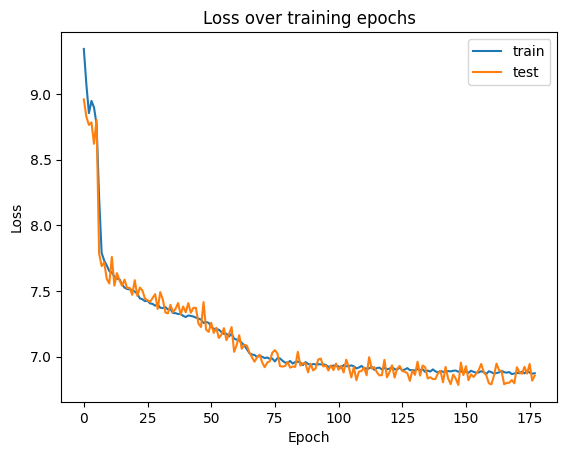

In [35]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

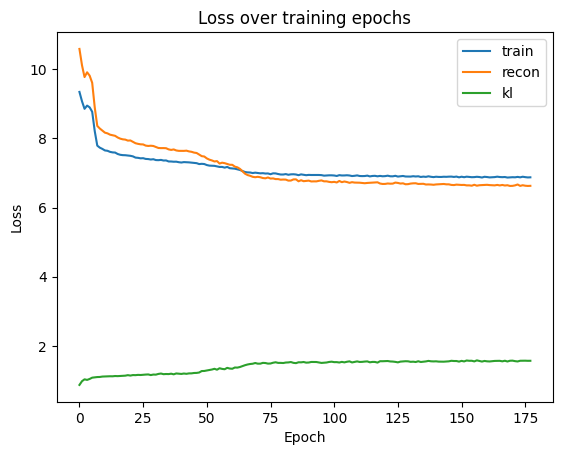

In [36]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['reconstruction_loss'])
ax.plot(history['kl_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'recon', 'kl'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

### Saving the model

Let's store the model for later use:

In [37]:
MODEL_PATH = 'model/model_VAE_100u_v4.pth'

torch.save(model, MODEL_PATH)

### Saving a history to file

In [38]:
import pickle

# save dictionary to person_data.pkl file
with open('history/model_VAE_100u_v4.pkl', 'wb') as fp:
    pickle.dump(history, fp)
    print('History dictionary saved successfully to file')

History dictionary saved successfully to file


### Load Model

Uncomment the next lines, if you want to download and load the pre-trained model:

In [29]:
# model = torch.load('./model/model_1_LSTM_AE.pth')
# model = model.to(device)

### Load History

In [30]:
# # Read dictionary pkl file
# with open('history/model_AE_100u_v1.pkl', 'rb') as fp:
#     history = pickle.load(fp)
#     print('History dictionary')
#     print(history.keys())

### Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [39]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            loss = reconstruction_loss + kl_div

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
            
    return predictions, losses, encoded, mean, std

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

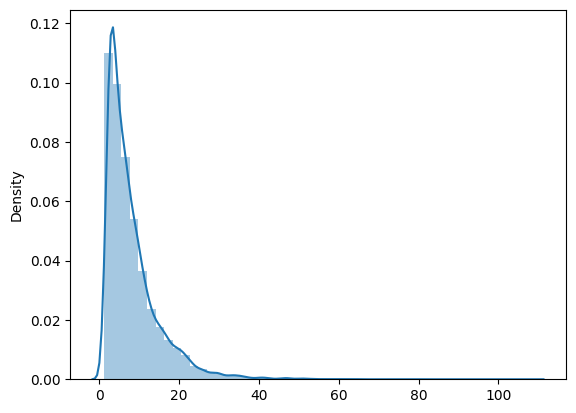

In [40]:
_, losses, _, mean, std = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [49]:
THRESHOLD = 20

### Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

* If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal energy consumption

Let's check how well our model does on normal datasets. We'll use the normal datasets from the test set (our model haven't seen those):

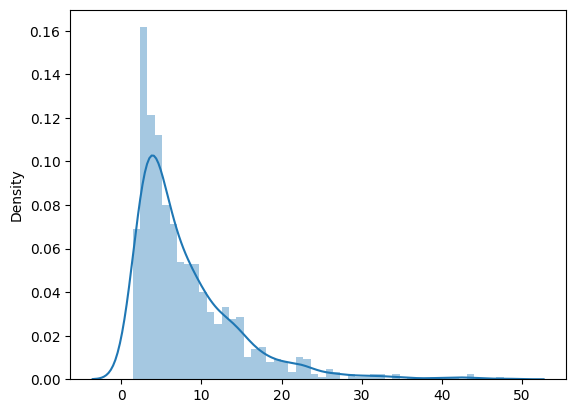

In [50]:
predictions, pred_losses, _, _, _ = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [51]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 887/941


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal datasets:

We can add this type of theif attacks

In [52]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

In [53]:
# predictions, pred_losses = predict(model, anomaly_dataset)
# sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [54]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses, _, _, _ = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    
    # ax[1].imshow(np.atleast_2d(pred_losses), aspect=5, cmap='Wistia')
    # ax[1].set_xticks([])
    # ax[1].set_yticks([])
    
    ax.legend()

In [55]:
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax.plot(data, label='true')
#     ax.plot(predictions[0], label='reconstructed')
#     ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')

#     ax.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.legend()

In [56]:
# from matplotlib.colors import LinearSegmentedColormap
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax1 = ax[0]
#     ax1.plot(data, label='true')
#     ax1.plot(predictions[0], label='reconstructed')
#     ax1.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
#     ax1.legend()
#     ax1.set_xlim(0, len(data))
    
#     # rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
#     ax2 = ax[1]
#     im = ax2.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     # fig.colorbar(im, ax=ax2)
#     return ax1, ax2

In [57]:
# fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# plot_prediction(data, model, title='Prediction', ax=axs)
# plt.tight_layout()
# plt.show()

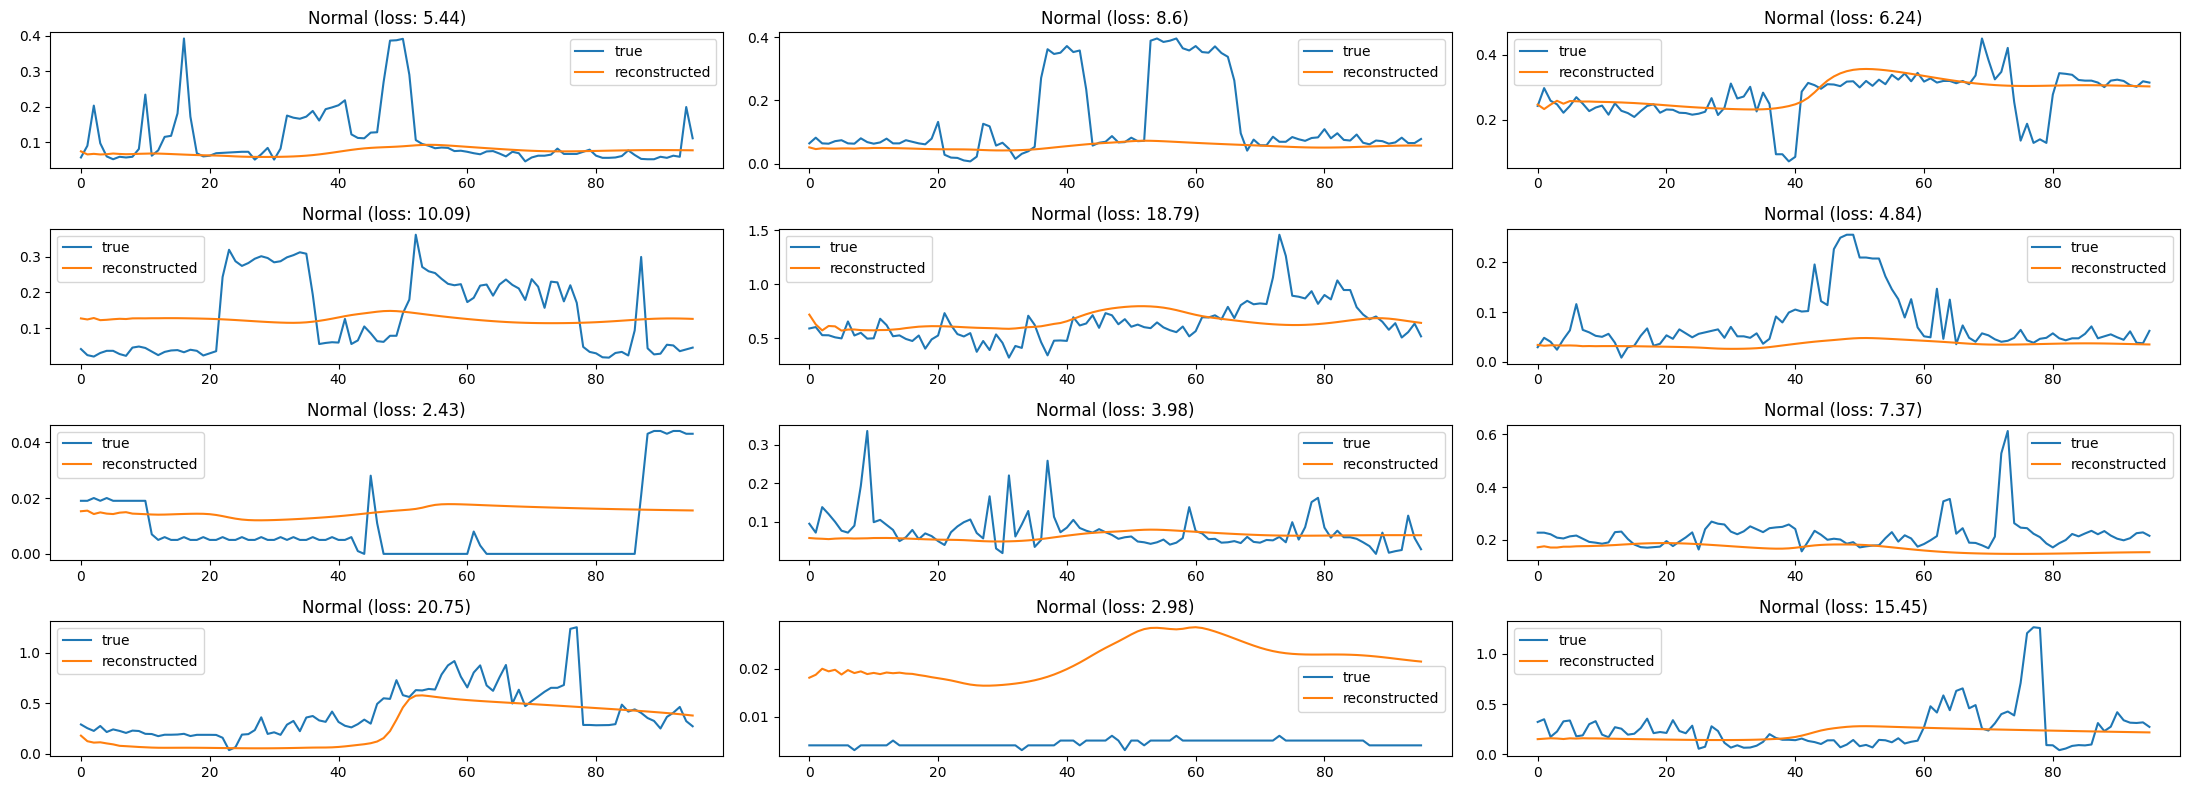

In [60]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(train_dataset[0:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(train_dataset[3:6]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(train_dataset[6:9]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(train_dataset[9:12]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

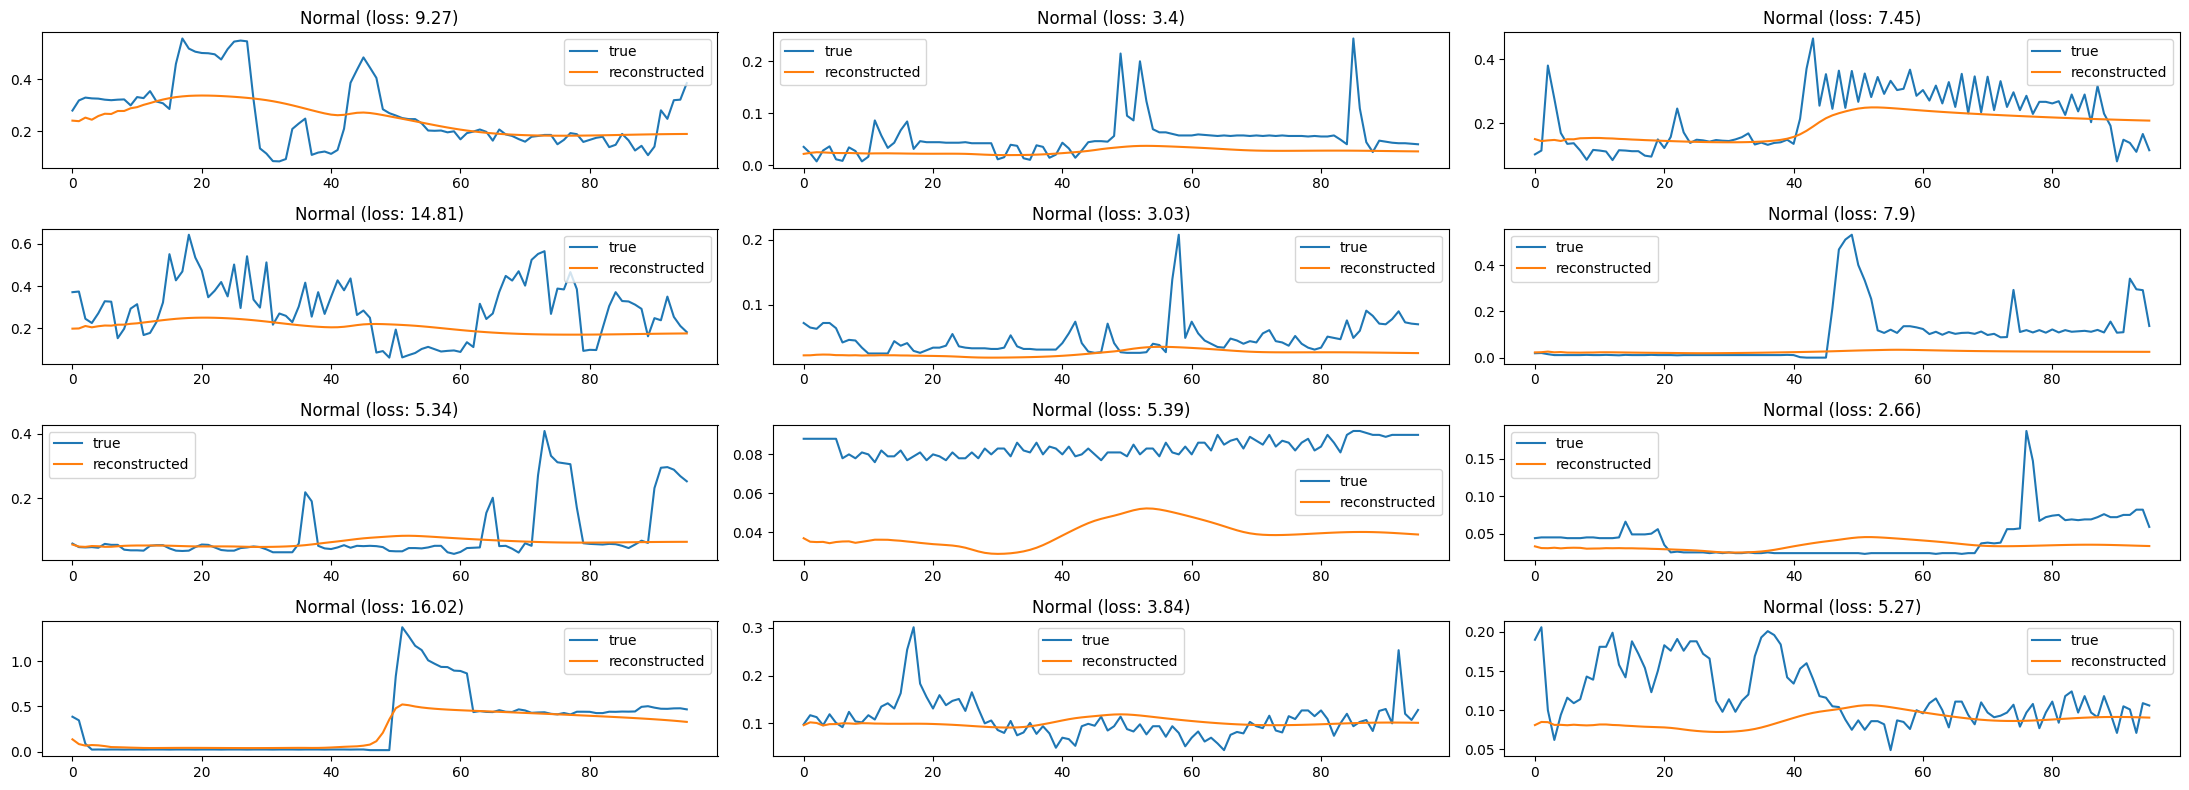

In [59]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[20:23]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(test_normal_dataset[23:26]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(test_normal_dataset[26:29]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(test_normal_dataset[29:32]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

### Test

## 5. Evaluate the model using the test set

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)